# Transformer Implementation from Scratch in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import os
import random
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


# Hyperparameters

In [2]:
hyperparameters = {
    'lags': 90,
    'forecast': 10,
    'input_features_size': 16,
    'date_input_features_size': 3, # (MONTH, DAY, HOUR)
    'date_features_dim': 64,
    'hidden_features_size': 256-64,
    'output_features_size': 16,
    'num_heads': 4,
    'ff_dim': 256*4, # usually 4 times the hidden feature size
    'num_decoder_layers': 6,
    'emb_dropout_prob': 0.1,
    'attn_dropout_prob': 0.1,
    'ff_dropout_prob': 0.1,
    'attn_use_bias': False,
    'ff_use_bias': False,
    'output_features_bias': False,
    'batch_size': 64,
    'split_ratio': 0.8, # 80% training, 20% testing
    'learning_rate': 0.001,
    'num_epochs': 100,
}

hyperparameters['window_size'] =  hyperparameters['lags'] + hyperparameters['forecast']

# Dataset

In [3]:
# Airline Passgeners
#df_full = pd.read_csv('data/airline_passengers/airline-passengers.csv')

# Panama Electricity Load Forecasting
df_full = pd.read_csv('data/panama_electricity_load_forecasting/train.csv')

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [4]:
# Airline Passgeners
#df_full['Month'] = pd.to_datetime(df_full['Month'])

# Panama Electricity Load Forecasting
df_full['datetime'] = pd.to_datetime(df_full['datetime'], dayfirst=True)

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [5]:
# # Airline Passgeners
#df_full.set_index('Month', inplace=True)

# Panama Electricity Load Forecasting
df_full.set_index('datetime', inplace=True)

df_full.tail()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-12-31 19:00:00,1301.6065,26.635645,0.018421,0.013165,13.184052,25.135645,0.018048,0.064240,3.086798,23.620020,0.016697,0.073425,3.865351,22,1,0
2019-12-31 20:00:00,1250.9634,26.495935,0.018162,0.014713,13.443892,24.769373,0.017781,0.058838,3.659980,23.284998,0.016606,0.064362,4.171572,22,1,0
2019-12-31 21:00:00,1193.6802,26.354456,0.017980,0.013836,13.442195,24.479456,0.017606,0.038086,3.769294,23.041956,0.016492,0.054260,4.045283,22,1,0
2019-12-31 22:00:00,1130.4575,26.166895,0.017965,0.018486,13.420656,24.112207,0.017393,0.020386,3.872397,22.862207,0.016401,0.055557,3.843736,22,1,0
2019-12-31 23:00:00,1084.4737,25.976373,0.018072,0.023315,13.749788,23.663873,0.017156,0.019531,4.165276,22.726373,0.016302,0.061371,3.793209,22,1,0


<Axes: xlabel='datetime'>

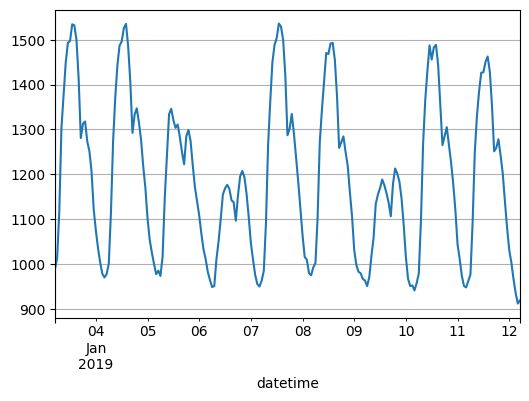

In [6]:
# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

# Standart Scaler
* Exercise: Try without scaler, see if learning works!

<Axes: xlabel='datetime'>

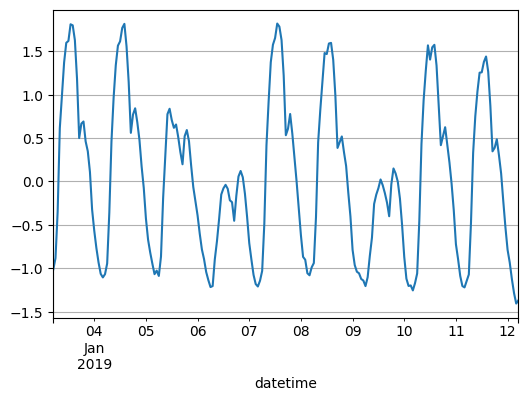

In [7]:
scaler = StandardScaler()

# Airline Passgeners
#df_full['Passengers'] = scaler.fit_transform(df_full['Passengers'].values.reshape(-1, 1))

# Panama Electricity Load Forecasting
df_full['nat_demand'] = scaler.fit_transform(df_full['nat_demand'].values.reshape(-1, 1))

# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

In [8]:
tstamp = df_full.index[-1]
tstamp

Timestamp('2019-12-31 23:00:00')

### Time series data shape: 
Unbatched: $(S, F)$

* $S:$ Sequence Length
* $F:$ Number of Features

Batched: $(B, S, F)$
* $B:$ Batch Size

In [9]:
df_full.shape

(43775, 16)

# Model

In [10]:
from models.transformer import GPTTimeSeries

## Transformer Model
### Initialized Model with Hyperparameters

In [11]:
model = GPTTimeSeries(
    input_features_size=hyperparameters['input_features_size'],
    date_input_features_size=hyperparameters['date_input_features_size'],
    date_features_dim=hyperparameters['date_features_dim'],
    features_dim=hyperparameters['hidden_features_size'],
    output_features_size=hyperparameters['output_features_size'],
    forecast_size=hyperparameters['forecast'],
    num_heads=hyperparameters['num_heads'],
    ff_dim=hyperparameters['ff_dim'],
    num_decoder_layers=hyperparameters['num_decoder_layers'],
    emb_dropout_prob=hyperparameters['emb_dropout_prob'],
    attn_dropout_prob=hyperparameters['attn_dropout_prob'],
    ff_dropout_prob=hyperparameters['ff_dropout_prob'],
    attn_use_bias=hyperparameters['attn_use_bias'],
    ff_use_bias=hyperparameters['ff_use_bias'],
    output_features_bias=hyperparameters['output_features_bias'],
)

### Number of parameters

In [12]:
def print_model_parameters(model):
    print(f'{sum(p.numel() for p in model.parameters()):,}')

In [13]:
print('Number of parameters:')
print_model_parameters(model)

Number of parameters:
4,732,864


In [14]:
dummy_data = torch.randn(hyperparameters['batch_size'], hyperparameters['window_size'], hyperparameters['input_features_size'])
dummy_date = torch.randn(hyperparameters['batch_size'], hyperparameters['window_size'], hyperparameters['date_input_features_size'])

o = model(dummy_data, dummy_date)
o.shape

torch.Size([64, 10, 16])

# Sliding Window 
*  **NOTE: "hyperparameters['lags'] + hyperparameters['forecast'] = hyperparameters['window_size']" MUST HOLD**

### Slide Methods

In [15]:
dummy_data = list(range(100))

# increase by 1
single_step = range(0, len(dummy_data)-hyperparameters['window_size']+1, 1)
# increase by hyperparameters['window_size']
window_step = range(0, len(dummy_data)-hyperparameters['window_size']+1, hyperparameters['window_size'])


#for start_index in single_step:
for start_index in window_step:
    print(f"Start: {start_index}, End: {start_index+hyperparameters['window_size']}")

    # Slice window from data 
    data_window = dummy_data[start_index:start_index+hyperparameters['window_size']]

    # Split current window into lags and forecast
    data_lag = data_window[:hyperparameters['lags']]
    data_forecast = data_window[-hyperparameters['forecast']:]

    print(f'Lag: {data_lag}, forecast: {data_forecast}')

Start: 0, End: 100
Lag: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], forecast: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


# Dataset

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, lags, forecast):
        self.df = df
        self.lags = lags
        self.forecast = forecast
        self.window_size = lags + forecast
        
    def __len__(self):
        number_of_samples = self.df.shape[0]
        # make sure that last window fits
        return number_of_samples - self.window_size

    def __getitem__(self, start_idx):

        # get a NumPy array of size: (hyperparameters['window_size'], NUM_FEATURES)
        df_window = self.df.iloc[start_idx:start_idx+self.window_size]

        sample_window = df_window.values
        # input (lag) timestamps
        sample_timestamp = df_window[:self.lags].index
            
        # divide window into lags and forecast:
        # (hyperparameters['lags'], NUM_FEATURES)
        lags = sample_window[:self.lags, :]
        # (hyperparameters['forecast'], NUM_FEATURES)
        forecast = sample_window[-self.forecast:, :]

        # convert to tensor
        lags = torch.tensor(lags, dtype=torch.float32)
        forecast = torch.tensor(forecast, dtype=torch.float32)
        # (lags, date_input_features_size)
        date = torch.tensor([sample_timestamp.month, sample_timestamp.day, sample_timestamp.hour], dtype=torch.float32).permute(1, 0)
        return lags, forecast, date

In [17]:
dataset_full = TimeSeriesDataset(
    df_full,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

In [18]:
_lags, _forecast, _date = dataset_full[0]
_lags.shape, _forecast.shape, _date.shape

(torch.Size([90, 16]), torch.Size([10, 16]), torch.Size([90, 3]))

### Train/Test Split

In [19]:
train_size = int(hyperparameters['split_ratio'] * len(dataset_full))
test_size = len(dataset_full) - train_size

train_size, test_size

(34940, 8735)

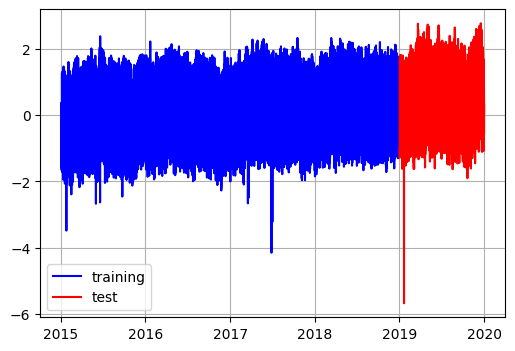

In [20]:
df_train = df_full.iloc[:train_size, :]
df_test = df_full.iloc[-test_size:, :]

# Airline Passgeners
#plt.plot(df_train.index, df_train['Passengers'], c='blue', label='training')
#plt.plot(df_test.index, df_test['Passengers'], c='red', label='test')

# Panama Electricity Load Forecasting
plt.plot(df_train.index, df_train['nat_demand'], c='blue', label='training')
plt.plot(df_test.index, df_test['nat_demand'], c='red', label='test')

plt.legend()

In [21]:
dataset_train = TimeSeriesDataset(
    df_train,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

dataset_test = TimeSeriesDataset(
    df_test,
    hyperparameters['lags'],
    hyperparameters['forecast'],
)

# Dataloader

In [22]:
dataloader_full = DataLoader(
    dataset_full,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=hyperparameters['batch_size'],
    shuffle=False,
)

print(f'Number of batches (total): {len(dataloader_full)}')
print(f'Number of batches (train): {len(dataloader_train)}')
print(f'Number of batches (test): {len(dataloader_test)}')

Number of batches (total): 683
Number of batches (train): 545
Number of batches (test): 135


In [23]:
_lags_batch, _forecast_batch, _date_batch = next(iter(dataloader_full))
# (hyperparameters['batch_size'], hyperparameters['lags'], NUM_FEATURES), # (hyperparameters['batch_size'], hyperparameters['forecast'], NUM_FEATURES)
_lags_batch.shape, _forecast_batch.shape, _date_batch.shape

(torch.Size([64, 90, 16]), torch.Size([64, 10, 16]), torch.Size([64, 90, 3]))

In [24]:
len(dataloader_full)

683

# Training

### Training Functions

In [25]:
def train_iter(model, dataloader, optimizer, criterion, device):
    model.train()

    avg_loss = []
    
    for (lags, forecast, date) in dataloader:

        lags = lags.to(device)
        forecast = forecast.to(device)
        date = date.to(device)
        
        optimizer.zero_grad()
    
        forecast_pred = model(lags, date)
        
        loss = criterion(forecast_pred, forecast)
        
        loss.backward()
        optimizer.step()

        avg_loss.append(loss.item())

    return sum(avg_loss) / len(avg_loss)


@torch.no_grad()
def eval_iter(model, dataloader, criterion, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    for (lags, forecast, date) in dataloader:
        
        lags = lags.to(device)
        forecast = forecast.to(device)
        date = date.to(device)
        
        forecast_pred = model(lags, date)

        loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        predictions.append(forecast_pred)

    return sum(avg_loss) / len(avg_loss), predictions

### Start Training

In [26]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparameters['learning_rate']
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', 
    factor=0.1, 
    patience=3,
    min_lr=1e-6,
)

mse_loss = nn.MSELoss()

In [27]:
model.to(device)

for epoch in range(1, hyperparameters['num_epochs']+1):
        
    avg_train_loss = train_iter(
        model=model, 
        dataloader=dataloader_train, 
        optimizer=optimizer, 
        criterion=mse_loss, 
        device=device
    )
    
    avg_test_loss, _ = eval_iter(
        model=model, 
        dataloader=dataloader_test, 
        criterion=mse_loss, 
        device=device
    )

    # auto decrease LR when not improving
    scheduler.step(avg_test_loss)
    
    """
    # MANUAL LR SCHEDULING
    if epoch == 30:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1

    if epoch == 60:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1
    """
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:<3}, Training loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}, LR: {scheduler.get_last_lr()}')

Epoch: 5  , Training loss: 2.9657, Testing Loss: 2.8543, LR: [0.001]
Epoch: 10 , Training loss: 1.9718, Testing Loss: 2.2527, LR: [0.001]
Epoch: 15 , Training loss: 1.7389, Testing Loss: 1.9744, LR: [0.001]
Epoch: 20 , Training loss: 1.5929, Testing Loss: 1.8471, LR: [0.001]
Epoch: 25 , Training loss: 1.5220, Testing Loss: 1.8662, LR: [0.001]
Epoch: 30 , Training loss: 1.4178, Testing Loss: 1.3197, LR: [0.0001]
Epoch: 35 , Training loss: 1.3018, Testing Loss: 1.2432, LR: [0.0001]
Epoch: 40 , Training loss: 1.2460, Testing Loss: 1.2138, LR: [0.0001]
Epoch: 45 , Training loss: 1.2141, Testing Loss: 1.2047, LR: [0.0001]
Epoch: 50 , Training loss: 1.1812, Testing Loss: 1.1833, LR: [0.0001]
Epoch: 55 , Training loss: 1.1633, Testing Loss: 1.1781, LR: [0.0001]
Epoch: 60 , Training loss: 1.1321, Testing Loss: 1.1550, LR: [1e-05]
Epoch: 65 , Training loss: 1.1259, Testing Loss: 1.1544, LR: [1e-05]
Epoch: 70 , Training loss: 1.1230, Testing Loss: 1.1528, LR: [1e-05]
Epoch: 75 , Training loss: 1

# Testing
* NOTE: we prefer to use single windows step during prediction

In [28]:
@torch.no_grad()
def eval_iter_single_step(model, dataloader, criterion, device):
    model.eval()

    avg_loss = []
    predictions = []
    
    # single step
    for start_idx in range(0, len(df_test)):

        # single step window sliding
        df_window = df_test.iloc[start_idx:start_idx+hyperparameters['window_size'], :]
        
        sample_window = df_window.values
        # input (lag) timestamps
        sample_timestamp = df_window[:hyperparameters['lags']].index

        # covnert to tensor
        lags = torch.tensor(sample_window[:hyperparameters['lags']], dtype=torch.float32, device=device)
        forecast = torch.tensor(sample_window[-hyperparameters['forecast']:], dtype=torch.float32, device=device)
        # (lags, date_input_features_size)
        date = torch.tensor([sample_timestamp.month, sample_timestamp.day, sample_timestamp.hour], dtype=torch.float32, device=device).permute(1, 0)
        
        # artificially add batch dimension
        # (we are not using the dataloader here!)
        lags = lags.unsqueeze(0)
        forecast = forecast.unsqueeze(0)
        date = date.unsqueeze(0)

        forecast_pred = model(lags, date)

        loss = criterion(forecast_pred, forecast)
        
        avg_loss.append(loss.item())
        # (batch, forecast, output_features_size)-> (1, 1, output_features_size)
        predictions.append(forecast_pred[0][0].cpu().numpy())

    return sum(avg_loss) / len(avg_loss), predictions

In [29]:
_, pred_sliding= eval_iter_single_step(
    model=model, 
    dataloader=dataloader_test, 
    criterion=mse_loss, 
    device=device
)

len(pred_sliding)

8735

In [30]:
df_full.columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [31]:
sliding_results_dict = {}

pred_sliding_array = np.array(pred_sliding)

for feature_id, feature_key in enumerate(df_full.columns):
    sliding_results_dict[feature_key] = pred_sliding_array[:, feature_id]
        
df_sliding = pd.DataFrame(data=sliding_results_dict, index=df_test.index)

df_sliding.head(10)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-01-02 01:00:00,-0.332601,26.407568,0.016478,0.023140,23.775955,25.457287,0.015788,0.032982,11.188055,23.540768,0.015314,0.089474,5.359266,-0.137366,0.023335,0.350477
2019-01-02 02:00:00,-0.432927,26.194944,0.016481,0.022163,23.010994,24.962694,0.015761,0.033524,10.599943,23.236013,0.015287,0.090961,5.451258,-0.074019,0.026729,0.291385
2019-01-02 03:00:00,-0.579978,25.858397,0.016334,0.015918,21.998806,24.147217,0.015752,0.030514,9.864913,22.725082,0.015172,0.089417,5.524519,0.043661,0.037508,0.100127
2019-01-02 04:00:00,-0.747303,25.616764,0.016173,0.024890,22.455082,23.789831,0.015591,0.036477,10.220790,22.437395,0.014980,0.094644,5.806593,0.196063,0.044801,0.068569
2019-01-02 05:00:00,-1.045614,25.602194,0.016360,0.039718,23.065807,23.732248,0.015587,0.044559,10.745091,22.329391,0.014982,0.101020,6.082380,0.195938,0.031676,0.192163
2019-01-02 06:00:00,-1.049783,25.351952,0.016197,0.040275,22.906713,23.368425,0.015508,0.046779,10.737515,22.076927,0.014848,0.103147,6.153341,0.279141,0.051398,0.117329
2019-01-02 07:00:00,-1.192755,25.499496,0.016290,0.044853,22.900188,23.722065,0.015438,0.048034,11.010184,22.239393,0.014860,0.101816,6.142591,0.116888,0.025943,0.240717
2019-01-02 08:00:00,-1.253479,25.441294,0.016255,0.033130,22.186367,23.482685,0.015449,0.039087,10.466470,22.063101,0.014900,0.095234,6.128394,0.124340,0.019952,0.174653
2019-01-02 09:00:00,-1.261178,25.270048,0.016242,0.026458,21.498104,23.181843,0.015411,0.035754,9.983561,21.791374,0.014892,0.092999,6.089877,0.146102,-0.002413,0.151444


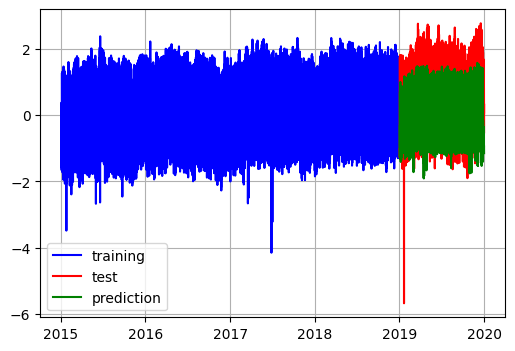

In [32]:
selected_feature = 'nat_demand'
plt.plot(df_train.index, df_train[selected_feature], c='blue', label='training')
plt.plot(df_sliding.index, df_test[selected_feature], c='red', label='test')
plt.plot(df_sliding.index, df_sliding[selected_feature] , c='green', label='prediction')
plt.legend()

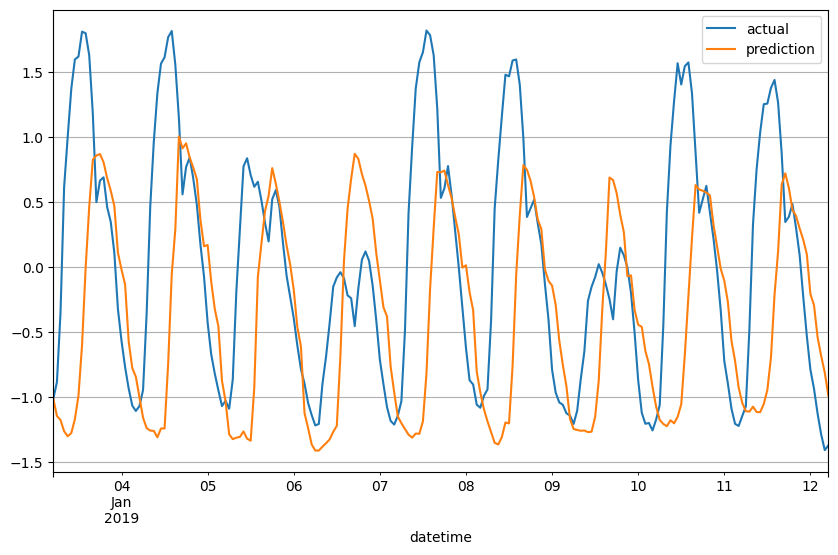

In [33]:
plt.figure(figsize=(10, 6))
df_test.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot(label='actual')
df_sliding.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot(label='prediction')
plt.legend()

# Save Model

In [34]:
os.makedirs('./saved_models', exist_ok=True)

torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hyperparameters': hyperparameters,
    },
    './saved_models/GPTTimeSeries.pt'
)

### Later: Push **df_sliding** to a database

# Generative Forecast

In [35]:
@torch.no_grad()
def generative_forecast(model, data, num_steps, lag_window_size):
    model.eval()
    
    predictions = []
    time_indexes = []

    _device = next(model.parameters()).device
    
    # covnert to tensor
    # data.shape: (lags, features)
    lags = torch.tensor(data[-lag_window_size:, :], dtype=torch.float32, device=_device)
    
    # artificially add batch dimension
    # (we are not using the dataloader here!)
    # data.shape: (1, lags, features)
    lags = lags.unsqueeze(0)

    # Datetime indexes 
    timestamps = df_full.index
    # Delta time: calculate the time difference between two samples 
    delta_time = timestamps[1] - timestamps[0]
    # Get last timestamp
    current_timestamp = timestamps[-1]

    def generate_date_tensor(_timestamp, _lags, _device):
        _timestamp = _timestamp[-lag_window_size:]
        return torch.tensor([_timestamp.month, _timestamp.day, _timestamp.hour], dtype=torch.float32, device=_device).permute(1, 0)
    
    # single step
    for idx in range(num_steps):

        # get the last lag steps
        lags = lags[:, -lag_window_size:, :]
        #print(lags)

        # date
        date = generate_date_tensor(timestamps, lag_window_size, device).unsqueeze(0)
        
        forecast_pred = model(lags, date)
        
        # (batch, forecast, output_features_size)-> (1, 1, output_features_size)
        predictions.append(forecast_pred[0][0].cpu().numpy())

        # update current timestamp
        current_timestamp = current_timestamp + delta_time
        time_indexes.append(current_timestamp)

        # append last forecast to the end
        lags = torch.cat((lags, forecast_pred.detach()), dim=1)

        # next timestamp
        timestamps = timestamps + delta_time

    return predictions, time_indexes

In [36]:
pred_generative, time_indexes_generative = generative_forecast(model, df_full.values, 150, hyperparameters['lags'])

pred_generative_array = np.array(pred_generative)

generative_results_dict = {}

# loop ove features
for feature_id, feature_key in enumerate(df_full.columns):
    generative_results_dict[feature_key] = pred_generative_array[:, feature_id]
        
df_generative = pd.DataFrame(data=generative_results_dict, index=time_indexes_generative)

<Axes: >

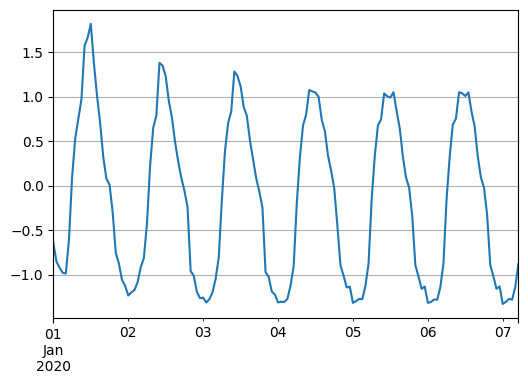

In [37]:
df_generative[selected_feature].plot()